In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import vegas
import gvar

In [3]:
def f(x):
    return 2 -3*x**2 + 4*x**4

In [4]:
def f_kde(x, x_rnd, weights, sigma=0.1):
    x = x.T * np.ones([len(x_rnd), len(x)])
    x_rnd = x_rnd.reshape(len(x_rnd), 1)
    weights = weights.reshape(len(weights), 1)
    x_dist = (x - x_rnd)
    f_kde_contribution = weights * norm.pdf(x_dist, 0, sigma)
    f_kde = f_kde_contribution.sum(axis=0)
    var_f_kde = np.sqrt((f_kde_contribution**2).sum(axis=0))
    return f_kde, var_f_kde

In [5]:
rng = np.random.default_rng()

In [6]:
x_rnd = rng.uniform(0, 1, 10000)
f_rnd = f(x_rnd)/len(x_rnd)

Text(0.5, 1.0, 'Test with N random = 10000')

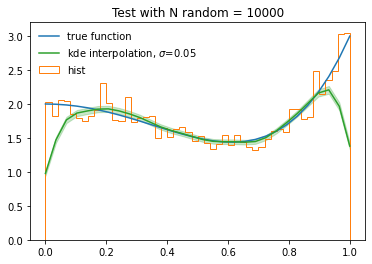

In [7]:
x_test = np.linspace(0., 1, 30)
plt.plot(x_test, f(x_test), label='true function')
bins = np.linspace(0, 1, 51)
plt.hist(x_rnd, bins=bins, weights=f_rnd/(bins[1] - bins[0]), label='hist', histtype='step')
# for sigma in [0.005, 0.05, 0.2]:
for sigma in [0.05]:
    f_est, var = f_kde(x_test, x_rnd, f_rnd, sigma)
    plt.plot(x_test, f_est, label=f'kde interpolation, $\sigma$={sigma}')
    plt.fill_between(x_test, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
plt.legend(frameon=False)
plt.title('Test with N random = 10000')

In [8]:
# playing with a counting experiment
x_rnd, y_rnd = rng.uniform(0, 1, 100000), rng.uniform(0, f(1), 100000)

In [9]:
f_rnd = f(x_rnd)
x_good_rnd = x_rnd[y_rnd < f_rnd]
w_rnd = np.ones(len(x_good_rnd)) * len(x_good_rnd)/len(x_rnd) * f(1) / len(x_good_rnd)

Text(0.5, 1.0, 'Test with N random = 10000')

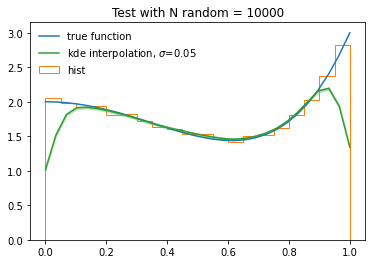

In [10]:
x_test = np.linspace(0, 1, 30)
plt.plot(x_test, f(x_test), label='true function')
bins = np.linspace(0, 1, 21)
plt.hist(x_good_rnd, bins=bins, weights=w_rnd/(bins[1] - bins[0]), label='hist', histtype='step')
# for sigma in [0.005, 0.05, 0.2]:
for sigma in [0.05]:
    f_est, var = f_kde(x_test, x_good_rnd, w_rnd, sigma)
    plt.plot(x_test, f_est, label=f'kde interpolation, $\sigma$={sigma}')
    plt.fill_between(x_test, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
    # plt.plot(x_test, len(x_good_rnd)/len(x_rnd) * f(1)*sum_kde(x_test, x_good_rnd, sigma), label=f'kde interpolation, $\sigma$={sigma}')
plt.legend(frameon=False)
plt.title('Test with N random = 10000')

In [11]:
# add a selection variable

In [12]:
def y(x):
    return rng.normal(x**2 -1, 1)

In [13]:
y_rnd = y(x_good_rnd)
rnd_passed = y_rnd > 0

x_rnd_passed = x_good_rnd[rnd_passed]
y_rnd_passed = y_rnd[rnd_passed]
w_rnd_passed = w_rnd[rnd_passed]

(0.0, 1.0)

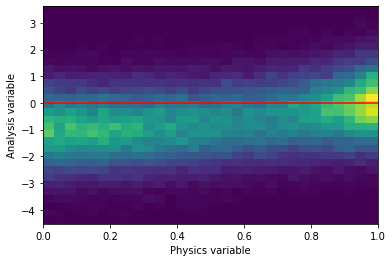

In [14]:
plt.hist2d(x_good_rnd, y_rnd, bins=(30, 30))
plt.xlabel('Physics variable')
plt.ylabel('Analysis variable')
plt.hlines(0, 0, 1, 'r')
plt.xlim(0, 1)

Text(0.5, 1.0, 'Test with N random = 100000')

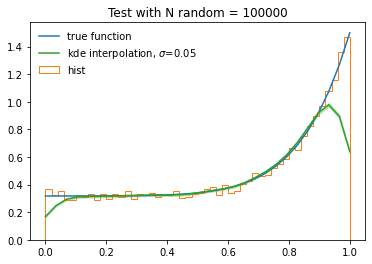

In [15]:
x_test = np.linspace(0, 1, 30)
plt.plot(x_test, f(x_test)*(1-norm.cdf(0, x_test**2-1, 1)), label='true function')

bins = np.linspace(0, 1, 51)
plt.hist(x_rnd_passed, bins=bins, weights=w_rnd_passed/(bins[1] - bins[0]), label='hist', histtype='step')

# for sigma in [0.005, 0.05, 0.2]:
for sigma in [0.05]:
    f_est, var = f_kde(x_test, x_rnd_passed, w_rnd_passed, sigma)
    plt.plot(x_test, f_est, label=f'kde interpolation, $\sigma$={sigma}')
    plt.fill_between(x_test, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
    # plt.plot(x_test, len(x_good_rnd)/len(x_rnd) * f(1)*sum_kde(x_test, x_good_rnd, sigma), label=f'kde interpolation, $\sigma$={sigma}')
plt.legend(frameon=False)
plt.title('Test with N random = 100000')

# test with importance sampling -- the hard way that I dont understand

In [103]:
# NOTE this is the hard way because we are insisting in integrating a function, 
# instead of a class when using the routine "integ.random_batch"! 
# See the 1D example for the "easy" way 
def f(var):
    x = var[0]
    mu = var[1]
#     normalisation = mu**2+1
#     mean = 3*mu -2
#     sigma = (mu*(mu+1)+ 0.5)
#     return normalisation*norm.pdf(x, mean, sigma)
    return x*mu**2


In [104]:
dx, dmu = 0.05, 0.05
# generate 2 2d grids for the x & y bounds
mu, x = np.mgrid[slice(0, 1 + dmu, dmu),
                slice(-3, 3 + dx, dx)]


Text(0.5, 0, '$x$ - analysis')

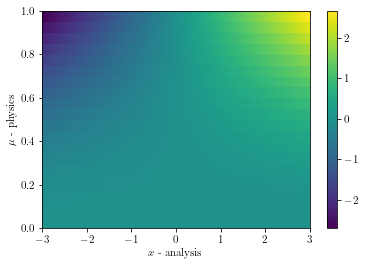

In [105]:
z = f([x, mu])
z = z[:-1, :-1]
plt.pcolormesh(x, mu, z)
plt.colorbar()
plt.ylabel(r'$\mu$ - physics')
plt.xlabel(r'$x$ - analysis')

In [106]:
integ = vegas.Integrator([[0, 1], [0, 1]])
result = integ(f, nitn=10, neval=100000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.1666654(65)   0.1666654(65)       0.00     1.00
  2   0.1666548(92)   0.1666618(53)       0.89     0.34
  3   0.1666639(83)   0.1666624(45)       0.47     0.63
  4   0.1666597(73)   0.1666617(38)       0.35     0.79
  5   0.1666674(72)   0.1666629(34)       0.38     0.82
  6   0.1666639(68)   0.1666631(30)       0.31     0.91
  7   0.1666679(66)   0.1666640(27)       0.33     0.92
  8   0.1666683(64)   0.1666646(25)       0.34     0.94
  9   0.1666694(61)   0.1666653(23)       0.36     0.94
 10   0.1666798(57)   0.1666674(22)       0.94     0.49



In [107]:
x_s = []
weight_s = []
integral = 0
# for x, wgt in integ.random_batch():
#     x_s.append(x.T)
#     weight_v.append(wgt)
#     weight_s.append(wgt * f(x.T))
#     integral += wgt.dot(f(x.T))

for x, wgt, hcube in integ.random_batch(yield_hcube=True):
    wgt_fx = wgt * f(x.T)
    integral += wgt.dot(f(x.T))
    for i in range(hcube[0], hcube[-1] + 1):
        idx = (hcube == i)          # select array items for h-cube i
        # get the weights from
        x_s.append(x[idx].T)
        weight_s.append(wgt[idx] * f(x[idx].T))

    
x_s = np.concatenate(x_s, axis=1)
weight_s = np.concatenate(weight_s)#/n_iterations


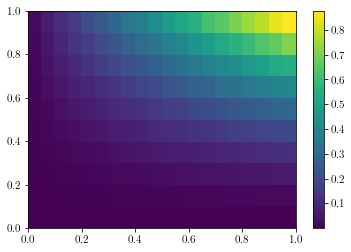

In [108]:
bins = (np.linspace(0, 1, 21), np.linspace(0, 1, 11))
bin_size = (bins[0][1]-bins[0][0]) * (bins[1][1]-bins[1][0])
import matplotlib.colors as colors
Z=weight_s/bin_size
plt.hist2d(x_s[0], x_s[1], bins=bins, weights=Z);
plt.colorbar()


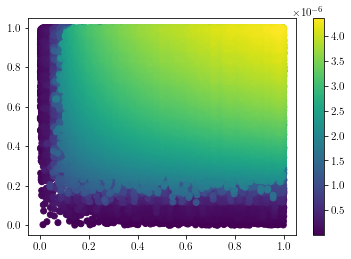

In [109]:
z=weight_s
idx = z.argsort()
x, y, z = x_s[0][idx], x_s[1][idx], z[idx]
plt.scatter(x,y,c=z);
plt.colorbar()

Text(0.5, 1.0, '$f = x y^2$')

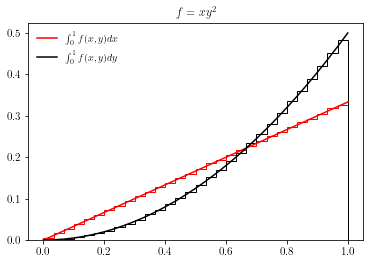

In [110]:
bins = np.linspace(0, 1, 31)
bin_size = (bins[1]-bins[0])
from matplotlib import rc, rcParams
rc('text', usetex=True)
fsize=11
params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize}
rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
rcParams.update(params)

plt.hist(x_s[0], bins=bins, weights=weight_s/bin_size, ec='red', fc='None', histtype='step');
plt.plot(bins, bins/3, c='red', label=r'$\int_0^1 f(x,y) dx$') # integral S x*y^2 dy = x * 1/3

plt.hist(x_s[1], bins=bins, weights=weight_s/bin_size, ec='black', fc='None', histtype='step');
plt.plot(bins, bins**2/2, c='black', label=r'$\int_0^1 f(x,y) dy$') # integral S x*y^2 dx = y^2 * 1/2
plt.legend(frameon=False, loc='upper left')
plt.title(r'$f = x y^2$')
 

# 1 D integration test -- the easy way

In [119]:
# NOTE that batch integrands are classes not functions in VEGAS
class baby(vegas.BatchIntegrand):
    def __init__(self,dim):
        self.dim = dim
    def __call__(self, x):
        return x[:, 0]
    

In [120]:
batch_f = baby(dim=1)
integ_baby = vegas.Integrator([[0, 1]])
# _ = integ_baby(batch_f, nitn=10, neval=1000)
result_baby = integ_baby(batch_f, nitn=50,neval=10000,adapt=True)#,max_nhcube=100)
# print(result_baby.summary())
print('VEGAS result = %s' % (result))

x_s = []
weight_s = []
for x, wgt in integ_baby.random_batch():
    wgt_fx = wgt*batch_f(x)
    weight_s = np.concatenate((weight_s,wgt_fx))
    x_s = np.concatenate((x_s,x[:,0]))
    
    

VEGAS result = 0.1666674(22)


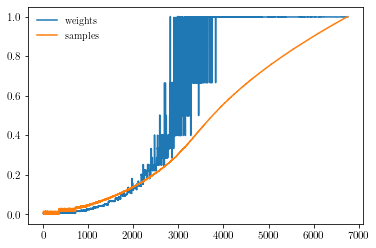

In [121]:
plt.plot(weight_s/np.max(weight_s),label='weights')
plt.plot(x_s,label='samples')
plt.legend(frameon=False,loc='upper left')


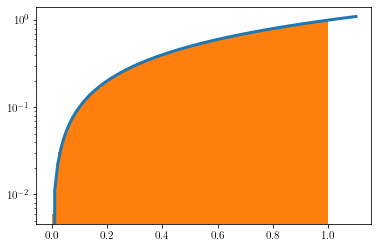

In [122]:
bins=np.linspace(0,1.1,100)
plt.plot(bins,bins,lw=3.0)
plt.yscale('log')
_=plt.hist(x_s, weights=(weight_s)/(bins[1]-bins[0]),bins=bins)
